** PCA and Logistic Regression**
For all computations in this project, the torch library is used. The torch package contains data structures for multi-dimensional tensors and mathematical operations over these are defined. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities.

# **1. Principal component analysis (PCA)**

Principal component analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize. PCA is also a very useful dimesnionality reduction technique. In the folowing, we explore how to apply PCA on the CIFAR dataset.

CIFAR 10 is a collection images which is commonly used to train machine learning and computer vision algorithms. This dataset contains 50000 training images and 10000 validation images such that the images can be classified between 10 different classes.  The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

**Getting the dataset using torchvision**

Torchvision is a pytorch package which helps in loading datasets in the image domain. It has dataloaders for common datasets like CIFAR 10, MNIST etc.

Torchvision returns the dataset in which every image is stretched out into a 3072-dimensional row vector.

The CIFAR dataset is loaded using torchvision. The labels are printed and some images with the corresponding labels.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


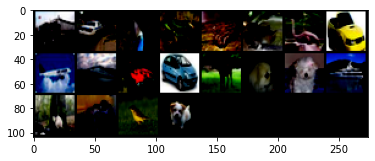

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import math

# Defining transformation function using torchvision.transforms to convert images into pytorch tensors
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# torchvision.datasets is used to load CIFAR-10 train dataset and the defined transform
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# torch.utils.data.DataLoader is used to get a python Iterable over the dataset, use batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=20,
                                          shuffle=True, num_workers=2)

# Getting the first batch of images of the dataset using python Iterator
train_iter = iter(train_loader)
images, labels = train_iter.next()

# Plotting the first batch of images of the training dataset
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Printing a few images of the training dataset.
imshow(make_grid(images))

# the labels are numbered from 0 - 9 as follows
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Centering and normalization**

PCA is applied on data after centering and normalization.

In [ ]:
def center(images):
    # The mean from the images is subtracted
    mean = torch.mean(images)
    centered_images = torch.add(images, -mean)
    return centered_images

def normalize(images):
    # Normalizing the centered images by dividing by the standard deviation
    normalized_images = torch.div(images, torch.std(images))
    return normalized_images

def transform_images(images):
  # reshaping the images as a 3072-dimensional row vector
  images = images.reshape((images.size()[0], 3072))
  images = center(images)
  images = normalize(images)
  return images

**Implementing PCA**

PCA takes in the data points and the target dimension which is lesser than the original dimension of the data. In this case, the data matrix is of [number of images, 3072].

The following presents the main steps to perform a slightly modified version of PCA. This function takes as input the original data points, and one of the two parameters: target_dim or target_variance. If target_dim is given then return the projected data into a target_dim-dimensional space. Otherwise, the function returns data projected into a low dimensional space which captures a ratio of target_variance from the data.


1.   Transforming the data by centering and normalizing the images
2.   Getting the data matrix of shape [#images, #dimensions]
3.   Computing the covariance matrix of the data matrix
4.   Computing the eigenvectors and eigenvalues of the covariance matrix
5.   Sorting eigenvectors by decreasing eigenvalues
6.   If target_variance is given then compute the target_dim corresponding to it.
7.   Selecting the top target_dim eigenvectors to get the encoding matrix of shape [target_dim, #dimesnions]
6.   Multipling the data matrix with the encoding matrix to project the data into the low dimensional space

In [ ]:
'''
PCA function must take the original images and either the number of target
dimensions or the ratio of the total variance to be captured from the data

'''
def PCA(images, target_dim = 0, target_variance = 0):
  # transforming the data
  data = transform_images(images)

  # Computing the covariance matrix of the data points
  cov = torch.matmul(data.t(), data)

  # Computing the eigenvectors and eigenvalues of the covariance matrix
  w, lamb = torch.eig(cov, eigenvectors=True)

  # Sorting eigenvectors by decreasing eigenvalues [2 points]
  w = w[:, 0]
  sorted_indices = torch.argsort(w, descending=True)
  w = w[sorted_indices]

  if(target_variance != 0):
    # Computing target_dim such that target_variance is captured from the data [2 points]
    target_dim = 1
    total_sum = torch.sum(w)
    while(torch.div(torch.sum(w[:target_dim]), total_sum) <= target_variance):
      target_dim += 1

  # Choosing target_dim eigenvectors corresponding to the low dimensional subspace
  encoding_matrix = lamb[sorted_indices[:target_dim]]

  # Multipling the data matrix with the encoding matrix to get the reduced dataset
  reduced_data = torch.matmul(data, encoding_matrix.T)

  return reduced_data, target_dim, encoding_matrix

**PCA for dimensionality reduction**

PCA is normally used to bring to acheive dimensionality reduction for high     dimensional datasets. This is acheived by bringing the dataset into a low dimensional subspace while still capturing most of the variance in the dataset. The above function is used to reduce the dataset into a 50 dimensional subspace.

In [ ]:
# dataloader with batch size 2000 to load the dataset is used
train_loader = DataLoader(train_dataset, batch_size=2000,
                                          shuffle=True, num_workers=2)
train_iter = iter(train_loader)
images, labels = train_iter.next()

# Applying PCA with target_d = 50 on the first batch (contains 2000 images) from the dataloader
reduced_data, _, _ = PCA(images, target_dim = 50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:3415.)
  


**PCA for visualization**

PCA is often used for visualization purposes.  Visually exploring the data can become challenging when we have more than 3 features. But this can be a very useful tool when dealing with data related problems.

The folowing code is done to create a scatterplot of the first and second principal components. Matplotlib is used for the following.

1.   Creating a 2D scatter plot. For each data point, the first principle component on $x$ axis is plotted and the second principle component on $y$ axis, use different colors for each class.
2.   Seting corresponding labels: assigning label "first principle component" for $x$ axis and "second principle component" for $y$ axis.
3.   Adding legends for each class.

From the plot below, the the first two principal components are clearly insufficient to separate any two classes.

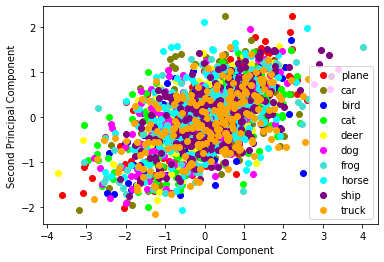

In [ ]:
# Creating a scatterplot of the first two dimensions of the reduced data
reduced_data, _, _ = PCA(images, target_dim = 2)
x = reduced_data[:, 0]
y = reduced_data[:, 1]
import numpy

colour_dict = {0:'red', 1:'olive', 2: 'blue', 3: 'lime', 4: 'yellow', 5: 'magenta',
             6: 'turquoise', 7: 'cyan', 8: 'purple', 9: 'orange'}
label_dict = {0:'plane', 1:'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
             6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
for label in range(10):
 indices = numpy.where(labels==label)
 plt.scatter(x[indices], y[indices], c=colour_dict[label], label=label_dict[label])

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.show()


---



# **Logistic regression**


Logistic regression is a classification algorithm used to assign observations to a discrete set of classes. Unlike linear regression which outputs continuous number values, logistic regression transforms its output using the logistic sigmoid function to return a probability value which can then be mapped to two or more discrete classes.

In this section, the binary logistic regression is explored. The clsssification problem is little changed with 10 classes into a binary classification problem by considering only the points from the classes *'ship'* and *'car'*.


**Generating training dataset**

Since logistic regression is a classification problem with two classes, a labelled dataset is needed with two classes as the training set. The function below is implemented to obtain the datapoints corresponding to labels *'ship'* and *'car'*.

The steps below:

1. Loading the train and test sets of CIFAR 10 from torchvision using a batch size of 1024.
2. Spliting the training samples by 80:20 ratio into train set and validation set respectively.
3. Filtering the datasets to only have images with classes 'ship' or 'car'. The corresponding labels are 8 and 1 respectively.
4. The new labels for binary classification problem should be 'ship' : 0 and 'car': 1.
5. A [torch.utils.data.Dataset] is defined with the filtered tensors of images and the newly created labels.
6. A dataloader needs to be defined for training and validation datasets with batch_size 64.


In [ ]:
# Generating the train, validation, and test sets from CIFAR 10
test_dataset = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
# Using torch.utils.data.DataLoader to get a python Iterable over the dataset
# loading the whole data to perform PCA
train_loader = DataLoader(train_dataset, batch_size=50000,
                                          shuffle=True, num_workers=2)
test_loader = DataLoader(train_dataset, batch_size=10000,
                                           shuffle=True, num_workers=2)

def filter(images, labels):
  car_indices = torch.tensor(np.where(labels==1)[0])
  ship_indices = torch.tensor(np.where(labels==8)[0])
  labels = torch.cat((torch.zeros(len(ship_indices)),
                    torch.ones(len(car_indices))))
  filtered_indices = torch.cat((ship_indices, car_indices)).numpy()
  images = images[filtered_indices]
  r = torch.randperm(len(images))
  images = images[r]
  labels = labels[r]
  return images, labels

train_iter = iter(train_loader)
images, labels = train_iter.next()
images, labels = filter(images, labels)

validation_data = images[-2000:], labels[-2000:]
training_data = (images[:8000], labels[:8000])
test_iter = iter(test_loader)
images, labels = test_iter.next()
test_data = filter(images, labels)

Files already downloaded and verified


**Getting the dataset in the low dimensional subspace**

Applying pca on the original data points to get new data matrix.
The target dimensions must capture 90% of the variance in the data.
Using the previously defined PCA function for this task. In the coming sections, this projected training dataset to training the logistic regression model will be used


In [ ]:
# Using the pca function defined in task 3 to reduce dimensions of the train set
reduced_data, target_dim, encoding_matrix = PCA(training_data[0], target_variance=0.9)
print('target dimension for 0.9 variance: ')
print(target_dim)

target dimension for 0.9 variance: 
88


**Logistic regression hypothesis**

In order to map predicted values to probabilities, logistic regression needs a function which returns values between 0 and 1. Logistic function is used in this case. This function maps any real value into another value between 0 and 1. In machine learning, it is also referred to as sigmoid and is used to map predictions to probabilities.

$f(x) = \frac{1}{1 + e^{-x}}$


In [ ]:
def sigmoid(x):
  # Finding and returning the sigmoid of x
  # 1.0 / (1.0 + torch.exp(-x))
  sigmoid_fn = nn.Sigmoid()
  return sigmoid_fn(x)

**Loss function**

A common loss function used when dealing with probabilities in binary classification is binary cross entropy loss.

$cross\_entropy\_loss(y, \hat y) = \frac{1}{N} \sum_{i=0}^{N} y\log \hat y_{i} + (1-y)\log (1 - \hat y_{i})$

For binary cross entropy loss, the number of classes is 2.

In [ ]:
def bce(y_true, y_pred):
  # Computing mean binary cross entropy loss given a list of predicted and true labels
  '''bce_loss = torch.mean(torch.mul(y_true, torch.log(y_pred)) +
                        torch.mul(1 - y_true, torch.log(1 - y_pred)))'''
  bce_loss = nn.BCELoss()
  return bce_loss(y_true, y_pred)

**Gradient descent to minimize the loss**

The logistic regression parameter need to be optimized to minimize the loss function.
The output of the logistic regression given a vector **x** is as follows.

$f(x) = \frac{1}{1 + e^{-wx}}$


In [ ]:
def gradient(loss):
  # Computing and returning the gradient of loss w.r.t the weight parameter
  loss.backward()

**Fitting the model**


The function below is implemented which fits a logistic regression model on the given input data with the specified learning rate and number of epochs using stochastic gradient descent.

The steps followed are mentioned below to complete the function.
```
For each epoch:
  For each mini batch:
    1. The predicted probabilities for all samples in the batch (y_pred) is computed
    2. The predicted probabilities for all samples in the batch (y_pred) is computed.
    3. The mean loss of the batch using function defined in the previous sectionis used.
    4. The gradient of the loss w.r.t the weight parameter is computed.
    5. Keeping the track of the mean loss during each epoch.
    6. Updating weight parameter using stochastic gradient descent. The batch size is 64, according to the dataloaders defined in previous section.
Returning the loss and the optimized weight parameter.
```


In [ ]:
def fit(data, epochs, learning_rate):

  '''The input x, which is multidimensional in this case, is multiplied
     with the logistic regression parameter W to get a scalar. This is then
     passed to the sigmoid function to get the probability. A tensor of
     the required shape is used to initialize the weight parameter
  '''
  torch.manual_seed(3)
  weight = torch.empty(target_dim, requires_grad=True)
  nn.init.normal_(weight, std=0.05)
  #weight = torch.randn(1, target_dim, requires_grad=True)
  num_of_batches = len(data)

  # looping over the data
  for epoch in range(epochs):
    net_loss = 0.0
    # for each mini batch
    for batch_x, batch_y in data:
      # Getting the predicted probabilites for the batch
      y_pred = sigmoid(torch.matmul(batch_x, weight))

      # Computed the mean loss of the batch
      loss = bce(y_pred, batch_y)
      net_loss += loss

      # Computed the gradient of the loss w.r.t weight
      weight.retain_grad()
      gradient(loss)
      # Performing one step of stochastic gradient descent to update weight
      weight = weight - learning_rate * weight.grad

    print('epoch: %d net_loss: %6.5f'%(epoch, net_loss/num_of_batches))
  return weight, net_loss/num_of_batches

**Hyperparameter tuning**

The learning rate and the number of epochs are important hyperparameters that need to be set before training.
The function below is implemented to select the best hyperparameters given the list of possible combinations.

In [ ]:
def select_best_hyperparams(data, learning_rates, epochs):
  # Initialize best loss
  best_loss = math.inf

  for learning_rate in learning_rates:#
    for epoch in epochs:#
      # Find the hyperparameter combination which returns the minimum loss after training (using fit function)
      _, cur_loss = fit(data, epoch, learning_rate)
      if(cur_loss < best_loss):
        best_loss = cur_loss
        best_hyperparams = learning_rate, epoch

  return best_hyperparams, best_loss

**Training using the best hyperparameters**

The code below is implemened to select the best hyperparamater combination and then fit the training data using the selected learning rate and number of epochs.



In [ ]:
# hyperparameters combinations
learning_rates = [0.01, 0.1, 1]
epochs = [25, 50, 100]
# validation data in the reduced subspace
data = torch.matmul(transform_images(validation_data[0]), encoding_matrix.T)
validation_set = TensorDataset(data , validation_data[1])
validation_loader = DataLoader(validation_set, batch_size = 64, shuffle=True)

# Using the function defined in precious section to find the best hyperparameter combination from the above list
best_hyperparams, _ = select_best_hyperparams(validation_loader, learning_rates, epochs)
print('Best hyperparameters using validation data.\nLearning rate: %5.3f, Number of epochs: %d '% (best_hyperparams[0], best_hyperparams[1]))

epoch: 0 net_loss: 0.64486
epoch: 1 net_loss: 0.58684
epoch: 2 net_loss: 0.55436
epoch: 3 net_loss: 0.53501
epoch: 4 net_loss: 0.52713
epoch: 5 net_loss: 0.51155
epoch: 6 net_loss: 0.50826
epoch: 7 net_loss: 0.50534
epoch: 8 net_loss: 0.49277
epoch: 9 net_loss: 0.49413
epoch: 10 net_loss: 0.48803
epoch: 11 net_loss: 0.48615
epoch: 12 net_loss: 0.47955
epoch: 13 net_loss: 0.47691
epoch: 14 net_loss: 0.47428
epoch: 15 net_loss: 0.47639
epoch: 16 net_loss: 0.47506
epoch: 17 net_loss: 0.47373
epoch: 18 net_loss: 0.47034
epoch: 19 net_loss: 0.47202
epoch: 20 net_loss: 0.46656
epoch: 21 net_loss: 0.46266
epoch: 22 net_loss: 0.46229
epoch: 23 net_loss: 0.46579
epoch: 24 net_loss: 0.46779
epoch: 0 net_loss: 0.64486
epoch: 1 net_loss: 0.58684
epoch: 2 net_loss: 0.55436
epoch: 3 net_loss: 0.53501
epoch: 4 net_loss: 0.52713
epoch: 5 net_loss: 0.51155
epoch: 6 net_loss: 0.50826
epoch: 7 net_loss: 0.50534
epoch: 8 net_loss: 0.49277
epoch: 9 net_loss: 0.49413
epoch: 10 net_loss: 0.48803
epoch: 11 ne

**Logistic regression threshold**

Logistic regression takes an input and returns a values between 0 and 1. To interpret this output as a probability of the input being in a class, a threshold needs to be defined. A threshold of 0.5 is set.

Class 0 is predicted if f(x) is greater than or equal to 0.5, else the data point is predicted to be of an instance of class 1.

The following function is implemented which predicts the class (ship or car) of a given input.

In [ ]:
threshold = 0.5

def predict(x, weight):
  # TODO : compute the predicted class label
  if(sigmoid(torch.matmul(x, weight)) > threshold):
    return 1
  else:
    return 0

**Reporting accuracy on test set**

The test set is used to give an indication of the generalization abilities of the model, that is to estimate how good the model is over random guessing at an unseen data point.

The code below  is implemented to compute the accuracy of logistic regression model on the test set. For this, first bringing the test set to the low dimensional subspace and then making predictions using the trained model.


In [ ]:
# Bringing the test set into the low dimesnional subspace defined earlier for the train set
data = torch.matmul(transform_images(test_data[0]), encoding_matrix.T)
test_set = TensorDataset(data , test_data[1])
test_loader = DataLoader(test_set, batch_size = 1)

#best_hyperparams = 0.1, 50
# fitting the model on training data with the best hyperparameter combination
train_set = TensorDataset(reduced_data, training_data[1])
train_loader = DataLoader(train_set, batch_size = 64)
weight, _ = fit(train_loader, best_hyperparams[1], best_hyperparams[0])

# Computing the accuracy on the reduced test set
acc = 0.0

for x, y in test_loader:
  if predict(x[0], weight) == y[0]:
    acc += 1.0
acc /= len(test_data[1])
print('Accuracy on the test set : %6.3f'% (acc))

epoch: 0 net_loss: 0.49433
epoch: 1 net_loss: 0.46198
epoch: 2 net_loss: 0.45586
epoch: 3 net_loss: 0.45290
epoch: 4 net_loss: 0.45124
epoch: 5 net_loss: 0.45025
epoch: 6 net_loss: 0.44962
epoch: 7 net_loss: 0.44920
epoch: 8 net_loss: 0.44892
epoch: 9 net_loss: 0.44872
epoch: 10 net_loss: 0.44858
epoch: 11 net_loss: 0.44848
epoch: 12 net_loss: 0.44841
epoch: 13 net_loss: 0.44835
epoch: 14 net_loss: 0.44831
epoch: 15 net_loss: 0.44828
epoch: 16 net_loss: 0.44826
epoch: 17 net_loss: 0.44824
epoch: 18 net_loss: 0.44822
epoch: 19 net_loss: 0.44821
epoch: 20 net_loss: 0.44820
epoch: 21 net_loss: 0.44820
epoch: 22 net_loss: 0.44819
epoch: 23 net_loss: 0.44819
epoch: 24 net_loss: 0.44818
epoch: 25 net_loss: 0.44818
epoch: 26 net_loss: 0.44818
epoch: 27 net_loss: 0.44818
epoch: 28 net_loss: 0.44817
epoch: 29 net_loss: 0.44817
epoch: 30 net_loss: 0.44817
epoch: 31 net_loss: 0.44817
epoch: 32 net_loss: 0.44817
epoch: 33 net_loss: 0.44817
epoch: 34 net_loss: 0.44817
epoch: 35 net_loss: 0.44817
ep